### Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

In [84]:
import random
import numpy as np
from matplotlib import pyplot as plt
from math import factorial
from scipy import stats as st
import math as mt
import pandas as pd

## Откроем файл с данными и изучим общую информацию

# Прочитаем данные из файлов 

In [85]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

# Выведем первые 10 строк и получим информацию о данных

In [86]:
display(calls.head(10))
#display(internet.head(10))
#display(messages.head(10))
#display(tariffs.head(10))
display(users.head(10))

#calls.info()
#internet.info()
#messages.info()
#tariffs.info()
#users.info()

#calls.describe()
#internet.describe()
#messages.describe()
#tariffs.describe()
#users.describe()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


## Подготовка данных

In [87]:
# Изменим тип данных из calls
calls = calls.astype({'id': int})
# столбец 'call_date' приведем к фрмату to_datetime
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')
# столбец 'duration' приведем к фрмату float32
calls = calls.astype({'duration': 'float32'})

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int64         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float32       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float32(1), int64(2)
memory usage: 5.4 MB


In [88]:
# Изменим тип данных из internet
internet = internet.astype({'id': int})
# столбец 'call_date' приведем к фрмату to_datetime
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')
# столбец 'duration' приведем к фрмату float32

internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  int64         
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 5.7 MB


In [89]:
# Изменим тип данных из messages
messages = messages.astype({'id': int})
# столбец 'message_date' приведем к фрмату to_datetime
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


In [90]:
# столбец 'call_date' приведем к фрмату to_datetime
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y-%m-%d')

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


Посчитаем для каждого пользователя:количество сделанных звонков и израсходованных минут разговора по месяцам.

In [91]:
# округляем минуты в большую сторону
calls['duration'] = np.ceil(calls['duration'])
calls['month'] = calls['call_date'].dt.month
total_calls = calls.pivot_table(index = ['user_id', 'month'], values = ['duration'], aggfunc = ['sum', 'count'])
total_calls.columns = ['minutes', 'count_durat']

display(total_calls.head(10))
#display(calls)

minutes  count_durat
user_id month                      
1000    5        159.0           22
        6        172.0           43
        7        340.0           47
        8        408.0           52
        9        466.0           58
        10       350.0           57
        11       338.0           43
        12       333.0           46
1001    11       430.0           59
        12       414.0           63

Посчитаем для каждого пользователя: количество отправленных сообщений по месяцам.

In [92]:
messages['month'] = messages['message_date'].dt.month
total_messages = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count')
total_messages.columns = ['count_message']
display(total_messages.head(10))

count_message
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
        10                73
        11                58
        12                70
1002    6                  4
        7                 11

Посчитаем для каждого пользователя: объем израсходованного интернет-трафика по месяцам.

In [93]:
internet['month'] = internet['session_date'].dt.month
total_session = internet.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum')
total_session.columns = ['internets']
display(total_session.head(10))

internets
user_id month           
1000    5        2253.49
        6       23233.77
        7       14003.64
        8       14055.93
        9       14568.91
        10      14702.49
        11      14756.47
        12       9817.61
1001    11      18429.34
        12      14036.66

# Обьединим все таблицы

In [94]:
total_tarif = total_calls.join([total_session, total_messages], how='outer')
display(total_tarif.head(10))

minutes  count_durat  internets  count_message
user_id month                                                
1000    5        159.0         22.0    2253.49           22.0
        6        172.0         43.0   23233.77           60.0
        7        340.0         47.0   14003.64           75.0
        8        408.0         52.0   14055.93           81.0
        9        466.0         58.0   14568.91           57.0
        10       350.0         57.0   14702.49           73.0
        11       338.0         43.0   14756.47           58.0
        12       333.0         46.0    9817.61           70.0
1001    11       430.0         59.0   18429.34            NaN
        12       414.0         63.0   14036.66            NaN

In [95]:
display(messages['id'].count())
total_tarif['count_message'].sum()

123036

123036.0

In [96]:
total_tarif = total_tarif.reset_index(level = 'month')
display(total_tarif)

,month,minutes,count_durat,internets,count_message
user_id,,,,,
1000,5,159.0,22.0,2253.49,22.0
1000,6,172.0,43.0,23233.77,60.0
1000,7,340.0,47.0,14003.64,75.0
1000,8,408.0,52.0,14055.93,81.0
1000,9,466.0,58.0,14568.91,57.0
...,...,...,...,...,...
1498,10,247.0,41.0,20579.36,42.0
1499,9,70.0,9.0,1845.75,11.0
1499,10,449.0,68.0,17788.51,48.0


In [97]:
total_tarif_table = users.join(total_tarif, on='user_id')

display(total_tarif_table)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,minutes,count_durat,internets,count_message
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,22.0,2253.49,22.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,43.0,23233.77,60.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,47.0,14003.64,75.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,52.0,14055.93,81.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,58.0,14568.91,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10.0,247.0,41.0,20579.36,42.0
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,9.0,70.0,9.0,1845.75,11.0
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,10.0,449.0,68.0,17788.51,48.0
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,11.0,612.0,74.0,17963.31,59.0


In [98]:
# Уберем лишние столбцы
total_tarif_table = total_tarif_table.drop(['churn_date', 'first_name', 'last_name', 'reg_date'], axis='columns')
display(total_tarif_table.head(10))

,user_id,age,city,tariff,month,minutes,count_durat,internets,count_message
0,1000,52,Краснодар,ultra,5.0,159.0,22.0,2253.49,22.0
0,1000,52,Краснодар,ultra,6.0,172.0,43.0,23233.77,60.0
0,1000,52,Краснодар,ultra,7.0,340.0,47.0,14003.64,75.0
0,1000,52,Краснодар,ultra,8.0,408.0,52.0,14055.93,81.0
0,1000,52,Краснодар,ultra,9.0,466.0,58.0,14568.91,57.0
0,1000,52,Краснодар,ultra,10.0,350.0,57.0,14702.49,73.0
0,1000,52,Краснодар,ultra,11.0,338.0,43.0,14756.47,58.0
0,1000,52,Краснодар,ultra,12.0,333.0,46.0,9817.61,70.0
1,1001,41,Москва,smart,11.0,430.0,59.0,18429.34,NaN
1,1001,41,Москва,smart,12.0,414.0,63.0,14036.66,NaN


In [99]:
# Переименуем столбец, чтобы было как в остальных столбцах
tariffs.rename(columns = {'tariff_name' : 'tariff'}, inplace = True)
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [100]:
# Обьеденим таблицы по тарифу
tariffs_table = tariffs.merge(total_tarif_table, on='tariff')
display(tariffs_table.head(10))

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,user_id,age,city,month,minutes,count_durat,internets,count_message
0,50,15360,500,550,200,3,3,smart,1001,41,Москва,11.0,430.0,59.0,18429.34,NaN
1,50,15360,500,550,200,3,3,smart,1001,41,Москва,12.0,414.0,63.0,14036.66,NaN
2,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,6.0,117.0,15.0,10856.82,4.0
3,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,7.0,214.0,26.0,17580.10,11.0
4,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,8.0,289.0,42.0,20319.26,13.0
5,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,9.0,206.0,36.0,16691.08,4.0
6,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,10.0,212.0,33.0,13888.25,10.0
7,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,11.0,243.0,32.0,18587.28,16.0
8,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,12.0,236.0,33.0,18113.73,12.0
9,50,15360,500,550,200,3,3,smart,1005,67,Набережные Челны,1.0,95.0,15.0,2727.97,7.0


Выведем на экран столбцы с нулевыми значениями, в столбце month, значения не можем заменить и удалим их, их всего 8 значений, в остальных столбцах заполним нулями. Как будто в это время не было использованных минут, трафика, смс.

In [101]:
#tariffs_table.isnull().sum()
tariffs_table = tariffs_table.dropna(subset=['month'])
tariffs_table.isnull().sum()
tariffs_table = tariffs_table.fillna(0)
#tariffs_table.isnull().sum()
display(tariffs_table.head(10))

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,user_id,age,city,month,minutes,count_durat,internets,count_message
0,50,15360,500,550,200,3,3,smart,1001,41,Москва,11.0,430.0,59.0,18429.34,0.0
1,50,15360,500,550,200,3,3,smart,1001,41,Москва,12.0,414.0,63.0,14036.66,0.0
2,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,6.0,117.0,15.0,10856.82,4.0
3,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,7.0,214.0,26.0,17580.10,11.0
4,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,8.0,289.0,42.0,20319.26,13.0
5,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,9.0,206.0,36.0,16691.08,4.0
6,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,10.0,212.0,33.0,13888.25,10.0
7,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,11.0,243.0,32.0,18587.28,16.0
8,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,12.0,236.0,33.0,18113.73,12.0
9,50,15360,500,550,200,3,3,smart,1005,67,Набережные Челны,1.0,95.0,15.0,2727.97,7.0


Посчитаем помесячную выручку для каждого пользователя.

In [102]:
def total_sum(row):
    message_sum = 0
    minut_sum = 0
    internet_sum = 0
    tariff = row['tariff']
    minutes = row['minutes']
    internets = row['internets']
    sms = row['count_message']
    price_minute = row['rub_per_minute']
    price_message = row['rub_per_message']
    price_gb = row['rub_per_gb']
    messages_included = row['messages_included']
    mb_included = row['mb_per_month_included']
    minutes_included = row['minutes_included']
    rub_monthly_fee = row['rub_monthly_fee']

    if minutes > minutes_included:
        minut_sum+=(minutes-minutes_included)*price_minute
    if internets > mb_included / 1024:
        internet_sum += (internets-mb_included/1024)*price_gb
    if sms > messages_included:
        message_sum += (sms-messages_included)*price_message
    return minut_sum + internet_sum + message_sum + rub_monthly_fee


# tariffs_table['totalls'] = tariffs_table.apply(total_sum, axis=1)
# tariffs_table['internets'] = np.ceil(tariffs_table['internets'] / 1024)

# Код ревьюера

tariffs_table['internets'] = np.ceil(tariffs_table['internets'] / 1024)
tariffs_table['totalls'] = tariffs_table.apply(total_sum, axis=1)


display(tariffs_table)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,user_id,age,city,month,minutes,count_durat,internets,count_message,totalls
0,50,15360,500,550,200,3,3,smart,1001,41,Москва,11.0,430.0,59.0,18.0,0.0,1150.0
1,50,15360,500,550,200,3,3,smart,1001,41,Москва,12.0,414.0,63.0,14.0,0.0,550.0
2,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,6.0,117.0,15.0,11.0,4.0,550.0
3,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,7.0,214.0,26.0,18.0,11.0,1150.0
4,50,15360,500,550,200,3,3,smart,1002,59,Стерлитамак,8.0,289.0,42.0,20.0,13.0,1550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1000,30720,3000,1950,150,1,1,ultra,1495,65,Иркутск,8.0,92.0,17.0,3.0,13.0,1950.0
3212,1000,30720,3000,1950,150,1,1,ultra,1495,65,Иркутск,9.0,813.0,112.0,33.0,82.0,2400.0
3213,1000,30720,3000,1950,150,1,1,ultra,1495,65,Иркутск,10.0,1030.0,152.0,29.0,82.0,1950.0
3214,1000,30720,3000,1950,150,1,1,ultra,1495,65,Иркутск,11.0,954.0,129.0,39.0,79.0,3300.0


## Анализ данных

# Проанализируем сколько по месяцам потратили в тарифах пользователи

In [103]:
totalls_month = tariffs_table.pivot_table(index = ['tariff', 'month', 'user_id'], values = ['minutes', 'count_durat', 'internets', 'count_message', 'totalls'], aggfunc='sum')
totalls_month = totalls_month.reset_index(level='month')
totalls_month = totalls_month.reset_index(level='tariff')
display(totalls_month)

,tariff,month,count_durat,count_message,internets,minutes,totalls
user_id,,,,,,,
1005,smart,1.0,15.0,7.0,3.0,95.0,550.0
1032,smart,1.0,61.0,38.0,24.0,380.0,2350.0
1045,smart,1.0,1.0,5.0,3.0,9.0,550.0
1055,smart,1.0,64.0,30.0,17.0,551.0,1103.0
1071,smart,1.0,24.0,16.0,16.0,194.0,750.0
...,...,...,...,...,...,...,...
1476,ultra,12.0,81.0,11.0,14.0,588.0,1950.0
1485,ultra,12.0,94.0,155.0,23.0,584.0,1950.0
1491,ultra,12.0,90.0,51.0,22.0,674.0,1950.0


In [104]:
# Выведем среднее
value_smart = totalls_month[totalls_month['tariff']=='smart'].mean()
value_ultra = totalls_month[totalls_month['tariff']=='ultra'].mean()
display(value_smart)
display(value_ultra)

month               8.346792
count_durat        58.463437
count_message      33.384029
internets          16.328847
minutes           417.934937
totalls          1289.973531
dtype: float64

month               8.250761
count_durat        73.392893
count_message      49.363452
internets          19.494416
minutes           526.623352
totalls          2070.152284
dtype: float64

Видим что в тарифе ультра средние значения больше, чем в тарифе смарт

In [105]:
# Посчитаем дисперсию
var_smart = np.var(totalls_month[totalls_month['tariff']=='smart'])
var_ultra = np.var(totalls_month[totalls_month['tariff']=='ultra'])
display(var_smart)
display(var_ultra)

month                 8.524419
count_durat         672.574370
count_message       796.455483
internets            33.013887
minutes           36203.066406
totalls          669485.220923
dtype: float64

month                 8.238642
count_durat        1926.731929
count_message      2282.946075
internets            96.993116
minutes          100771.226562
totalls          141373.073256
dtype: float64

По всем параметрам в тарифе ультра дисперсия больше, кроме общего значения

In [106]:
# Посчитаем среднее отклонение
standart_dev_smart = np.sqrt(var_smart)
standart_dev_ultra = np.sqrt(var_ultra)
display(standart_dev_smart)
display(standart_dev_ultra)

month              2.919661
count_durat       25.934039
count_message     28.221543
internets          5.745771
minutes          190.271034
totalls          818.220765
dtype: float64

month              2.870303
count_durat       43.894555
count_message     47.780185
internets          9.848508
minutes          317.444840
totalls          375.996108
dtype: float64

среднее отклонения также в тарифе ультра больше, кроме общего занчения.

Построим гистограммы, для тарифа смарт, для тарриф ультра.

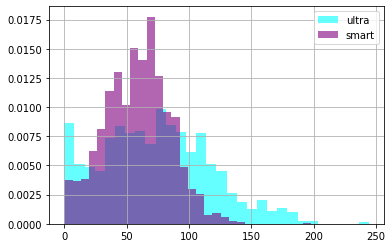

In [107]:
tariffs_table[tariffs_table['tariff'] == 'ultra']['count_durat'].hist(bins=30, density=True, label='ultra', alpha=0.6, color='cyan')
tariffs_table[tariffs_table['tariff'] == 'smart']['count_durat'].hist(bins=30, density=True, label='smart', alpha=0.6, color='purple')
plt.legend();

По гисторгамме видим количество звонков больше в тарифе ультра, хотя в тарифе смарт больше совершают звонков. 

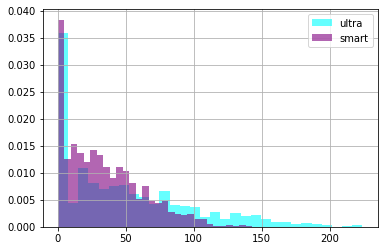

In [108]:
tariffs_table[tariffs_table['tariff'] == 'ultra']['count_message'].hist(bins=30, density=True, label='ultra', alpha=0.6, color='cyan')
tariffs_table[tariffs_table['tariff'] == 'smart']['count_message'].hist(bins=30, density=True, label='smart', alpha=0.6, color='purple')
plt.legend();

В тарифе ультра смс больше.

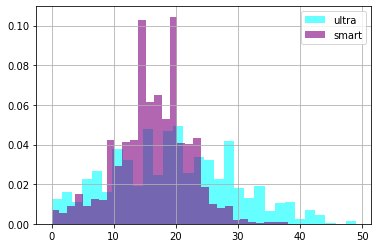

In [109]:
tariffs_table[tariffs_table['tariff'] == 'ultra']['internets'].hist(bins=30, density=True, label='ultra', alpha=0.6, color='cyan')
tariffs_table[tariffs_table['tariff'] == 'smart']['internets'].hist(bins=30, density=True, label='smart', alpha=0.6, color='purple')
plt.legend();

Интернет трафик также больше людей использует в тарифе ультра, хотя максимальное значение  трафика в тарифе ультра.

In [110]:

tariffs_table[tariffs_table['internets'] == tariffs_table['internets'].max()]

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,user_id,age,city,month,minutes,count_durat,internets,count_message,totalls
2458,1000,30720,3000,1950,150,1,1,ultra,1124,54,Махачкала,10.0,1225.0,152.0,49.0,121.0,4800.0


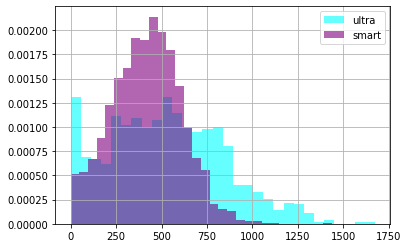

In [111]:
tariffs_table[tariffs_table['tariff'] == 'ultra']['minutes'].hist(bins=30, density=True, label='ultra', alpha=0.6, color='cyan')
tariffs_table[tariffs_table['tariff'] == 'smart']['minutes'].hist(bins=30, density=True, label='smart', alpha=0.6, color='purple')
plt.legend();

Клиенты ультры часто используют в месяц больше минут, чем клиенты Смарта

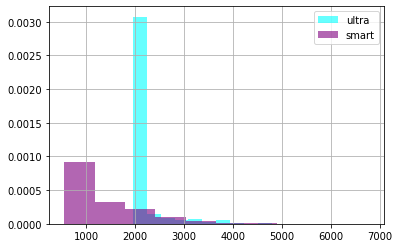

In [112]:
tariffs_table[tariffs_table['tariff'] == 'ultra']['totalls'].hist(bins=10, density=True, label='ultra', alpha=0.6, color='cyan')
tariffs_table[tariffs_table['tariff'] == 'smart']['totalls'].hist(bins=10, density=True, label='smart', alpha=0.6, color='purple')
plt.legend();

Выручка от тарифа смарт больше

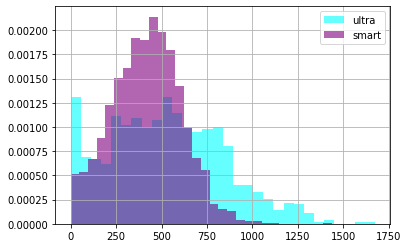

In [113]:
# Код ревьюера

tariffs_table[tariffs_table['tariff'] == 'ultra']['minutes'].hist(bins=30, density=True, label='ultra', alpha=0.6, color='cyan')
tariffs_table[tariffs_table['tariff'] == 'smart']['minutes'].hist(bins=30, density=True, label='smart', alpha=0.6, color='purple')
plt.legend();

## Проверка гипотезы

Используем гипотезу о равенстве средних двух генеральных совокупностей методом scipy.stats.ttest_ind().


За нулевую гипотезу Ho примем что средняя выручка пользователей тарифов «Ультра» и «Смарт» равны(Ho всегда со знаком равенства)

За альтернативную гипотезу берем H1 средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [114]:
display(totalls_month.head())

#totalls_month.drop('tariff_y', inplace=True, axis=1)

#display(totalls_month.head())
#totalls_month.rename(columns = {'tariff_x' : 'tariff'})
#display(totalls_month.head())

,tariff,month,count_durat,count_message,internets,minutes,totalls
user_id,,,,,,,
1005,smart,1.0,15.0,7.0,3.0,95.0,550.0
1032,smart,1.0,61.0,38.0,24.0,380.0,2350.0
1045,smart,1.0,1.0,5.0,3.0,9.0,550.0
1055,smart,1.0,64.0,30.0,17.0,551.0,1103.0
1071,smart,1.0,24.0,16.0,16.0,194.0,750.0


In [115]:
smart_test = totalls_month[totalls_month['tariff']=='smart']['totalls']
ultra_test = totalls_month[totalls_month['tariff']=='ultra']['totalls']

# уровень значимости 5%
alpha = 0.05
# устанавливаем значение equal_var=False, потому что мы знаем что дисперсии не равны
results = st.ttest_ind(smart_test, ultra_test, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:

    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Выручка тарифов отличается друг от друга.

In [116]:
# Расчитаем среднею выручку тарифа смарт
totalls_smart_mean = totalls_month[totalls_month['tariff']=='smart']['totalls'].mean()
display(totalls_smart_mean)

1289.9735307312696

In [117]:
# Расчитаем среднею выручку тарифа ультра
totalls_ultra_mean = totalls_month[totalls_month['tariff']=='ultra']['totalls'].mean()
display(totalls_ultra_mean)

2070.1522842639592

In [118]:
# Процентное соотношение
print("{:.3%}".format((totalls_ultra_mean / totalls_smart_mean)))

160.480%


Средняя выручка от тарифа ультра составляет всего лишь 31% тарифа смарт.

In [119]:
totalls_month = totalls_month.merge(users[['tariff','city', 'user_id']], on='user_id')

display(totalls_month.head(10))

,user_id,tariff_x,month,count_durat,count_message,internets,minutes,totalls,tariff_y,city
0,1005,smart,1.0,15.0,7.0,3.0,95.0,550.0,smart,Набережные Челны
1,1005,smart,2.0,69.0,38.0,8.0,456.0,550.0,smart,Набережные Челны
2,1005,smart,3.0,77.0,56.0,11.0,606.0,886.0,smart,Набережные Челны
3,1005,smart,4.0,101.0,41.0,10.0,712.0,1186.0,smart,Набережные Челны
4,1005,smart,5.0,73.0,42.0,8.0,595.0,835.0,smart,Набережные Челны
5,1005,smart,6.0,80.0,47.0,10.0,612.0,886.0,smart,Набережные Челны
6,1005,smart,7.0,77.0,56.0,8.0,569.0,775.0,smart,Набережные Челны
7,1005,smart,8.0,71.0,64.0,8.0,619.0,949.0,smart,Набережные Челны
8,1005,smart,9.0,66.0,52.0,7.0,479.0,556.0,smart,Набережные Челны
9,1005,smart,10.0,100.0,44.0,8.0,723.0,1219.0,smart,Набережные Челны


In [120]:
# Код ревьюера

totalls_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        3214 non-null   int64  
 1   tariff_x       3214 non-null   object 
 2   month          3214 non-null   float64
 3   count_durat    3214 non-null   float64
 4   count_message  3214 non-null   float64
 5   internets      3214 non-null   float64
 6   minutes        3214 non-null   float32
 7   totalls        3214 non-null   float64
 8   tariff_y       3214 non-null   object 
 9   city           3214 non-null   object 
dtypes: float32(1), float64(5), int64(1), object(3)
memory usage: 263.6+ KB


За нулевую гипотезу Ho примем средняя выручка пользователей из Москвы равна от выручки пользователей из других регионов.
За альтернативную гипотезу берем H1 средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [121]:
test_moscow = totalls_month[totalls_month['city']=='Москва']['totalls']
smart_no_moscow = totalls_month[totalls_month['city']!='Москва']['totalls']

# уровень значимости 5%
alpha = 0.05

results = st.ttest_ind(test_moscow, smart_no_moscow)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:

    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Выручка по Москве отличаеться от выручки других городов.

## Вывод

Средние чеки тарифов смарт и ультра значимо различаются.Выручка от тарифа смарт больше.

Выручка по Москве отличается от других городов.